In [65]:
import numpy as np
from matplotlib import pyplot as plt
import h5py as h5

In [66]:
file = h5.File('./lcdm150.h5')

In [67]:
data = file['potential']

In [68]:
data[1]

array([[ 33.72499904, -13.97083192,   6.28445604, ...,  27.8250361 ,
         20.33999578,  48.62112365],
       [  8.47777502,   9.54388783,  -1.19985091, ...,  18.26843716,
         -0.88608814,  10.97970788],
       [-18.13167787,   4.92991946,  -4.97209096, ...,  -5.26195905,
        -13.81645163, -10.56987963],
       ...,
       [-19.20051822, -43.80457222, -32.55984295, ..., -28.43487353,
        -24.38678805, -15.25587918],
       [ -9.82905139, -24.04862497,  -8.65321082, ..., -25.55679873,
        -23.51334556, -26.05559049],
       [  2.40395036,  18.92341102,   3.13886183, ...,   2.23640112,
         10.36198202,  -2.66538429]])

In [63]:
file.close()

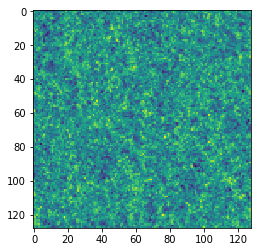

In [69]:
plt.imshow(data[50])

In [70]:
X = (np.arange(128)*150./128)[np.indices([128,128,128])]

In [71]:
X_abs = np.sqrt((X**2).sum(axis=0))

In [72]:
Y = (X + 150/2) % 150 - 150/2

In [73]:
Y_abs = np.sqrt((Y**2).sum(axis=0))

In [74]:
mask = np.where(Y_abs < 8.0, 1.0, 0.0)
mask /= mask.sum()

In [75]:
from numpy import fft

In [76]:
filtered = fft.ifftn(fft.fftn(data) * fft.fftn(mask)).real

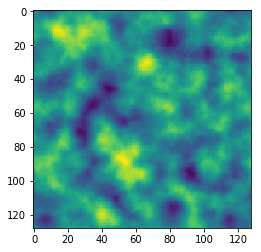

In [77]:
plt.imshow(filtered[0])

In [78]:
filtered.std()

3.0416129100629163

In [79]:
data[:].std()

20.702835356287846

In [80]:
q = fft.fftn(mask)

In [82]:
z = (q * q.conj()).real

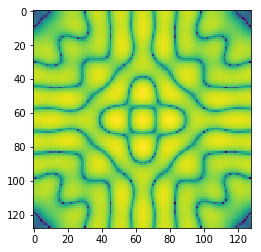

In [85]:
plt.imshow(np.log(z[50]))